# Twitter users gender classification

Ramet Gaétan, Schloesing Benjamin, Yao Yuan

## Introduction

The objective of this project is to find features which can help to determine a Twitter user's gender using machine learning.

## Step 1 : Import data

The dataset we will use is the [Twitter User Gender Classification](https://www.kaggle.com/crowdflower/twitter-user-gender-classification) dataset made available by [Crowdflower](https://www.crowdflower.com/). This datasets contains 20000 entries, each of them being a tweet from different users, with many other associated features which are listed here:

* **_unit_id** : a unique id for each user
* **_golden** : a boolean which states whether the user is included in the golden standard for the model
* **_unit_state** : the state of the obervation, eiter *golden* for gold standards or *finalized* for contributor-judged
* **_trusted_judgments** : the number of judgment on a user's gender. 3 for non-golden, or a unique id for golden
* **_last_judgment_at** : date and time of the last judgment, blank for golden observations
* **gender** : either *male*, *female* or *brand* for non-human profiles
* **gender:confidence** : a float representing the confidence of the gender judgment
* **profile_yn** : either *yes* or *no*, *no* meaning that the user's profile was not available when contributors went to judge it
* **profile_yn:confidence** : confidence in the existence/non-existence of the profile
* **created** : date and time of when the profile was created
* **description** : the user's Tweeter profile description
* **fav_number** : the amount of favorited tweets by the user
* **gender_gold** : the gender if the profile is golden
* **link_color** : the link color of the profile as a hex value
* **name** : the Tweeter user's name
* **profile_yn_gold** : *yes* or *no* whether the profile y/n value is golden
* **profileimage** : a link to the profile image
* **retweet_count** : the number of times the user has retweeted something
* **sidebar_color** : color of the profile sidebar as a hex value
* **text** : text of a random tweet from the user
* **tweet_coord** : if the location was available at the time of the tweet, the coordinates as a string ith the format[latitude, longitude]
* **tweet_count** : number of tweet of the users
* **tweet_created** : the time of the random tweet in **text**
* **tweet_id** : the tweet id of the random tweet
* **tweet_location** : the location of the tweet, based on the coordinates
* **user_timezone** : the timezone of the user

Most of these features are not relevant for our analysis, we will only focus on a few of them, i.e. the colors of the sidebars and links, the texts in the description and in the tweets and finally, the content of the profile picture

In [14]:
import pandas as pd
import numpy as np
from IPython.display import display
import re

#graph
from bokeh.plotting import output_notebook, figure, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource

%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

from matplotlib import pyplot as plt
# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

from collections import Counter


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from sklearn import linear_model, metrics
from sklearn import naive_bayes

from twtgender import *

# we need latin-1 encoding because there are some special characters (é,...) that do not fit in default UTF-8
dataFrame = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin-1')

#Show a sample of the dataset
dataFrame.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229096808449/fYvzqXN7_normal.png,0,FFFFFF,Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t....,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221532700673/WW16tBbU_normal.jpeg,0,C0DEED,ÛÏIt felt like they were my friends and I was living the story with themÛ https://t.co/arngE0...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418249658368/SBLCXdF7_normal.png,1,C0DEED,i absolutely adore when louis starts the songs it hits me hard but it feels good,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936/IMG_8444_normal.JPG,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you use @IFTTT?! Don't typically see an advanced use...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871032446976/AOfpk-mr_normal.jpeg,0,0,Watching Neighbours on Sky+ catching up with the Neighbs!! Xxx _Ù÷Ä_Ù÷Ä_Ù÷Ä_ÙÔÎ_ÙÈ_ÙÔ_ÙÈ Xxx,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


# Step 2: Data exploration




## Color features exploration

The first feature we are going to use for our analysis are the **link_color** and **sidebar_color**. On Twitter, it is possible to personalize your account by changing the colors of the links or the sidebars, and we expect people from different gender to have different behaviors in how they personalize their page. For example, we can expect females to use more "girly" colors such as pink or purple, while men would keep it more "manly" with some blue maybe.

We wrote the **colorsGraphs** function to extract and plot the most used colors for sidebars and for links by each gender. As the color is not especially easy to deduce from its HEX code, we found it easier to read to plot each bar in its associated color. The first thing we can notice is that most users do not personalize their page much and keep one of the standard Twitter themes, regardless of their gender. In order to better visualize how the personalization differs, we removed these most used themes from the bar graphs.

<IPython.core.display.Javascript object>


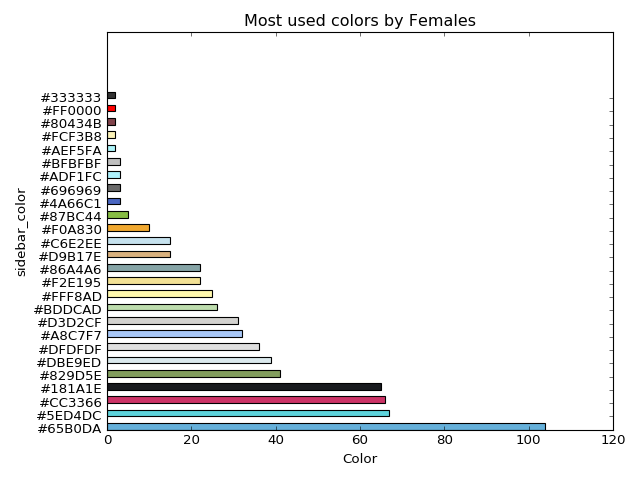

<IPython.core.display.Javascript object>


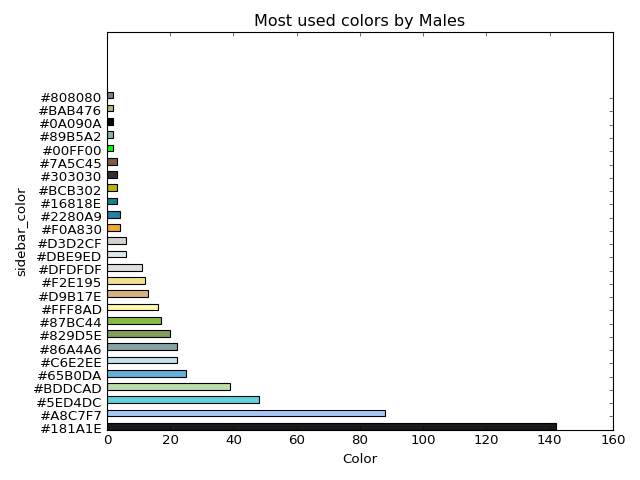

<IPython.core.display.Javascript object>


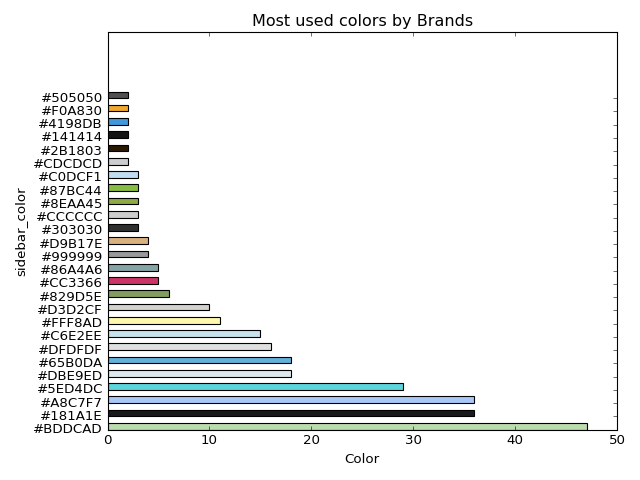

<IPython.core.display.Javascript object>


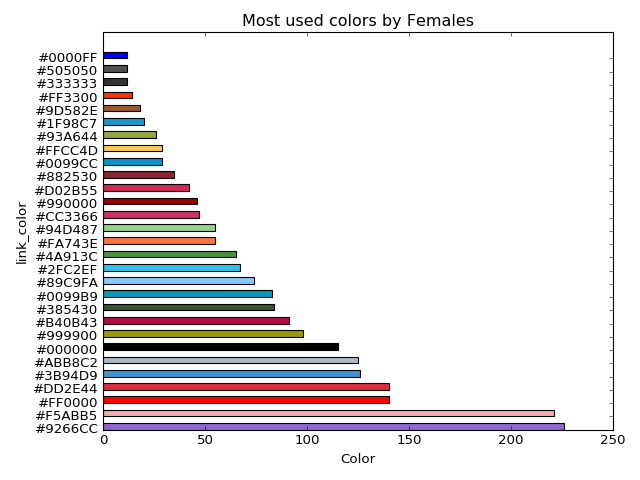

<IPython.core.display.Javascript object>


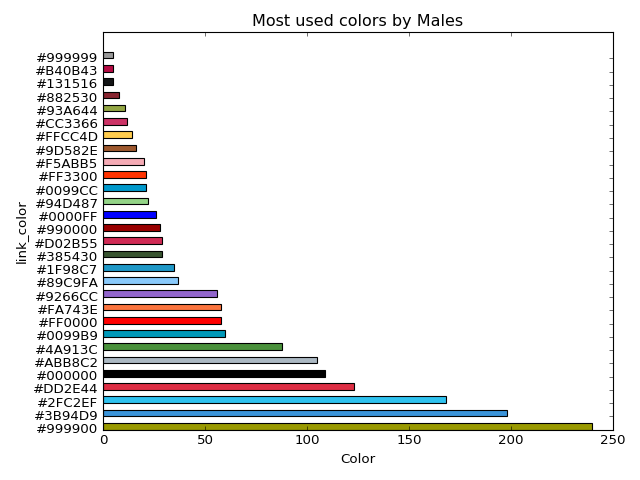

<IPython.core.display.Javascript object>


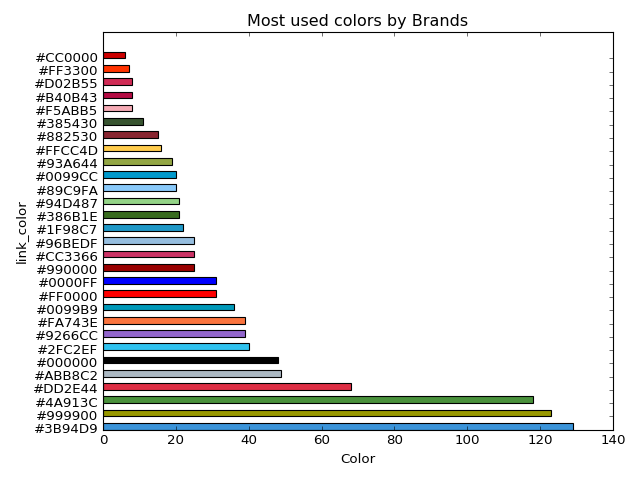

In [2]:
#Data Exploration Colors
colorsGraphs(dataFrame, 'sidebar_color', 1, 4)
colorsGraphs(dataFrame, 'link_color', 1, 1)

From the graphs, we can take the following conclusions:
* First it seems like users tend to change their link color more than their sidebar color
* Female users have indeed a preference for purple, pink and red colors, while male users tends to use more green and blue. Brands usually hae their paes in blue or green as well

These are only intuitions confirmed by the data, but if we want to predict the gender using the colors, we need a prediction model. 

## Text features exploration

Now that wwe have seen how users personalize the color of their pages, let's have a deeper look at what they actually write on Twitter. Here, we will explore bot the text from the users descriptions but also the text from the tweets themselves. As these two texts lies on different cells in the dataframe, we will first need to process it a bit. The first thing we wanted to do was to normalize the text by removing separators suchs as commas, and also normalize the text itself to have only lowercase letters. To do so, we wrote the **text_normalizer** function. We then grouped the description and tweet texts together. Finally, we wrote the **compute_bag_of_words** and **print_most_frequent** functions to visualize which words are most used by which genders

C:\Users\Gaet_2\Anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:318: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = N.ndarray.__getitem__(self, index)


<IPython.core.display.Javascript object>


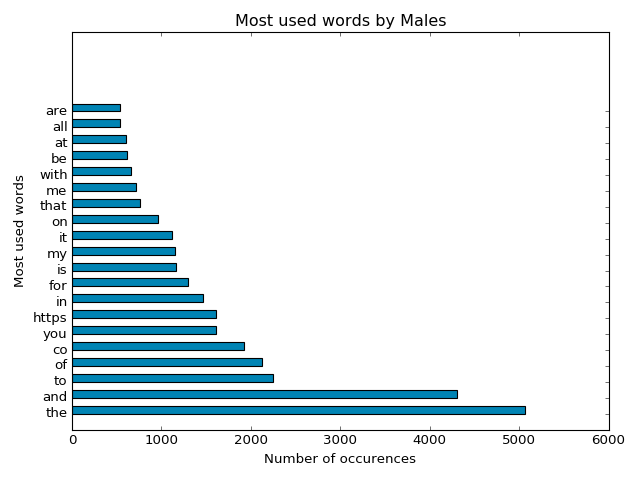

<IPython.core.display.Javascript object>


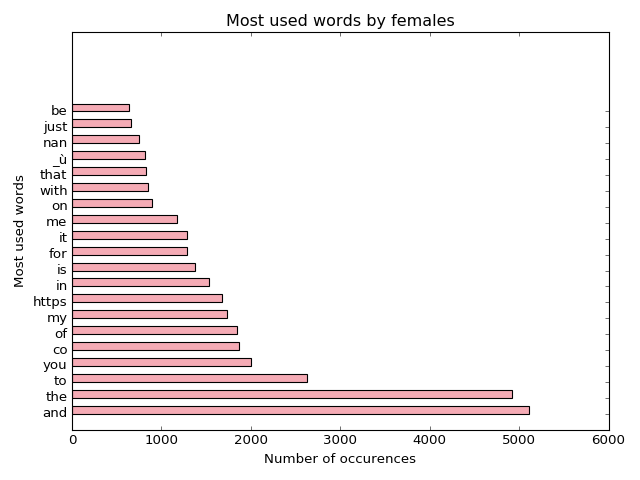

<IPython.core.display.Javascript object>


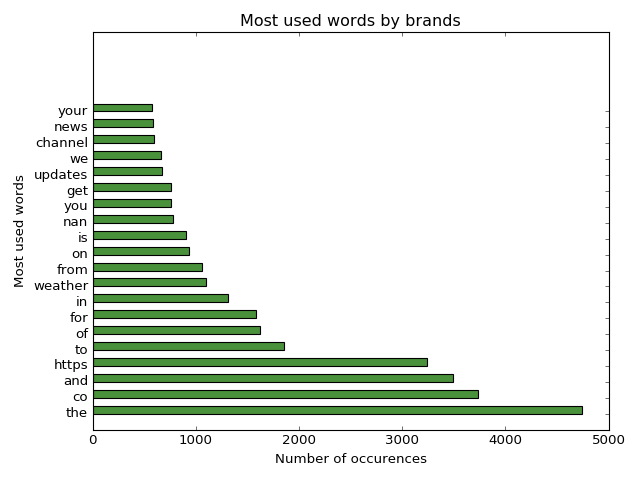

In [3]:
#Data Exploration - Text
# Normalize text in the descriptions and tweet messages

# Adding dict to the dataframe containing normalized texts 
dataFrameText = dataFrame
dataFrameText['text_norm'] = [text_normalizer(s) for s in dataFrameText['text']]
dataFrameText['description_norm'] = [text_normalizer(s) for s in dataFrameText['description']]

# Now let's put all the interesting text, i.e. the description and the tweeet itself in one string for each tweet
dataFrameText['all_text'] =dataFrameText['text_norm'].str.cat(dataFrameText['description_norm'],sep=' ')
dataFrameText = dataFrameText[(dataFrameText['gender:confidence']==1)&(dataFrameText['gender']!='unknown')]

# Extract separate genders dataframes
male_data = dataFrameText[dataFrameText['gender']=='male']
female_data = dataFrameText[dataFrameText['gender']=='female']
brand_data = dataFrameText[dataFrameText['gender']=='brand']
male_data.head()
        
male_bow, male_voc = compute_bag_of_words(male_data['all_text'])
print_most_frequent(male_bow, male_voc, 'male')

female_bow, female_voc = compute_bag_of_words(female_data['all_text'])
print_most_frequent(female_bow, female_voc, 'female')

brand_bow, brand_voc = compute_bag_of_words(brand_data['all_text'])
print_most_frequent(brand_bow, brand_voc, 'brand')
#nothing special about these words really

The results are not quite as conclusive as with the colors. In fact, the most used words, regardless of the gender, are very simple words such as "the", "and", "to" or "of", and this does not give us any information about the gender really. One intersting thing we noticed is that the brands tends to use the words "weather", "channel" and "news" more than regular male and female users. This means that we have probably many information or weather channels accounts in our database. Another interesting fact is on the usage of the word "https". It seems like brands tend to post more links than standard users.

## Profile picture features exploration

To use the profile pictures information is a bit more difficult than using simple text or color codes. The first thing we need to do is to extract the picture content from the picture itself. To do so, we used [Clarify API](https://www.clarifai.com/api), however, as the process is very long to run on the whole dataFrame (approximately 12 hours), we do not recommend to run the code. Instead, we created a new dataFrame containing all the picture contents keyword, which we will use in further analysis.

Now that the we have the content of the profile pictures in text, we can run the same data exploration process than earlier, and see which contents is most used by which gender

In [4]:
#Data Exploration - Pictures

#import imghdr 
#import requests 
#import io
#import urllib.request as ur
#from clarifai.rest import ClarifaiApp
#app = ClarifaiApp()


## We used clariai api to do image extraction, which takes about 12 hours 
## . Thus, We set all the codes into comments avoiding running again.

#raw_data['pic_text']=' '
#for i in range(20048,20049): 
    
#    url=raw_data['profileimage'][i]
#    index=url.rfind('.')
#    url_new=url[:index-7]+url[index:]
#    if '.gif' not in url_new:
#        if 'pb.com'not in url_new:
#            response = requests.get(url_new)
#            if(response.status_code != 404):
#                result=app.tag_urls([url_new])
#                for k in range(0,4):
#                    if(k==0):
#                        raw_data['pic_text'][i]=result['outputs'][0]['data']['concepts'][k]['name']
#                    else:
#                        raw_data['pic_text'][i]=raw_data['pic_text'][i] + ' ' + result['outputs'][0]['data']['concepts'][k]['name']
##                print(i)
##            print(raw_data['pic_text'][i])    



#new_data=raw_data
#df = pd.DataFrame(new_data, columns = ['gender', 'gender:confidence', 'profileimage', 'pic_text'])
#df.to_csv('new_data.csv')

new_data=pd.read_csv('new_data.csv',encoding='latin-1')
#Show a sample of the dataset
new_data.head()

,Unnamed: 0,gender,gender:confidence,profileimage,pic_text
0,0,male,1.0000,https://pbs.twimg.com/profile_images/414342229...,music people fun fashion
1,1,male,1.0000,https://pbs.twimg.com/profile_images/539604221...,man people portrait one
2,2,male,0.6625,https://pbs.twimg.com/profile_images/657330418...,
3,3,male,1.0000,https://pbs.twimg.com/profile_images/259703936...,
4,4,female,1.0000,https://pbs.twimg.com/profile_images/564094871...,man people portrait two


C:\Users\Gaet_2\Anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:318: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = N.ndarray.__getitem__(self, index)


<IPython.core.display.Javascript object>


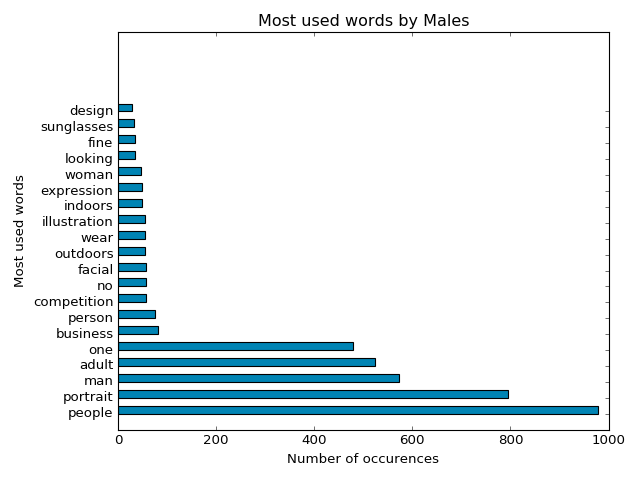

<IPython.core.display.Javascript object>


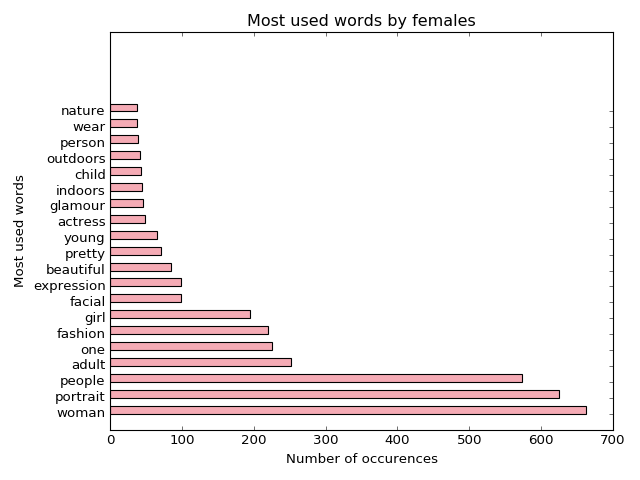

<IPython.core.display.Javascript object>


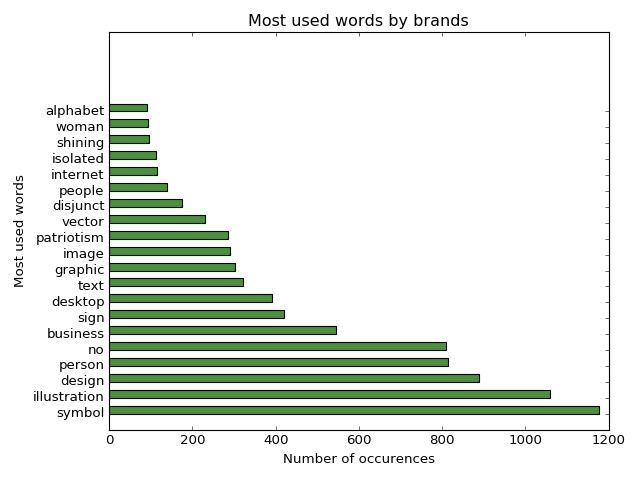

In [5]:
#create separate gender dataFrames
male_data = new_data[(new_data['gender']=='male')&(new_data['gender:confidence']==1)&(new_data['pic_text']!=' ')]
female_data = new_data[(new_data['gender']=='female')&(new_data['gender:confidence']==1)&(new_data['pic_text']!=' ')]
brand_data = new_data[(new_data['gender']=='brand')&(new_data['gender:confidence']==1)&(new_data['pic_text']!=' ')]
genderConf = new_data[(new_data['gender:confidence']==1)&(new_data['gender']!='unknown')&(new_data['pic_text']!=' ')]

male_bow, male_voc = compute_bag_of_words(male_data['pic_text'])
print_most_frequent(male_bow, male_voc,'male')
#print('----------------------------')

female_bow, female_voc = compute_bag_of_words(female_data['pic_text'])
print_most_frequent(female_bow, female_voc,'female')
#print('----------------------------')

brand_bow, brand_voc = compute_bag_of_words(brand_data['pic_text'])
print_most_frequent(brand_bow, brand_voc,'brand')

The results here are very interesting. First we can notice that as it is supposed to be a "profile picture", most male and female users use a picture, which is why the words "adult", "people", "portrait" and respectively "man" and "woman" are the most recurrent. Regarding the brands side, mots of the pictures are "symbol", "illustration" or "design", which means they are probably logos of the brand themselves. 

# Step 3: Prediction model


## Gender Prediction based on color features

We wrote the **predictors** function to extract the best predictors and anti-predictors of one specific feature for gender prediction. Here, we applied it to the **link_color**, using different linear models for the prediction. We chose to use linear models because they are simple, but still good enough to be efficient, and have a nice implementaion in the **sklearn** library. 

More specifically, these models have an attribute called **coef_** which gives the weight of each word (here, the color HEX codes) of the model. A word that has a high weight for a given gender means that, if a user make use of it, it has a strong probability of being of this specific gender.

First, we performed the clasification work using the color features:

Testing Ridge Classifier model for gender prediction using link_color
Split: 2755 testing and 11023 training samples
model:  Ridge Classifier
mse: 1.0635
score:  0.44500907441
Testing SGD Classifier model for gender prediction using link_color
Split: 2755 testing and 11023 training samples
model:  SGD Classifier
mse: 0.7332
score:  0.40943738657
Testing Logistic regression model for gender prediction using link_color
Split: 2755 testing and 11023 training samples
model:  Logistic regression
mse: 1.0966
score:  0.452268602541
Testing Passive Aggressive Classifier model for gender prediction using link_color
Split: 2755 testing and 11023 training samples
model:  Passive Aggressive Classifier
mse: 1.3260
score:  0.396007259528
Testing Multinnomial NB model for gender prediction using link_color
Split: 2755 testing and 11023 training samples
model:  Multinnomial NB
mse: 1.1318
score:  0.443194192377


<IPython.core.display.Javascript object>


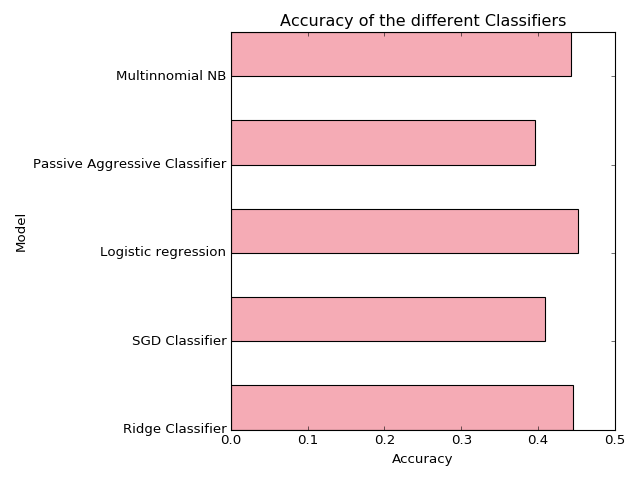

In [15]:
# Classifier colors

dataFrameColor = dataFrame.loc[:,['gender:confidence', 'gender', 'link_color']]
dataFrameColorFiltered = dataFrameColor[(dataFrameColor['gender:confidence'] == 1)&(dataFrameColor['link_color'].str.contains('E\+') != True)&(dataFrameColor['gender']!='unknown')]

feature = 'link_color'
df = dataFrameColorFiltered

# List of the classifiers we tested
modelListColor = [linear_model.RidgeClassifier(), 
             linear_model.SGDClassifier(),
             linear_model.LogisticRegression(),
             linear_model.PassiveAggressiveClassifier(),
             naive_bayes.MultinomialNB()]
modelNamesList = ['Ridge Classifier', 
                  'SGD Classifier',
                  'Logistic regression',
                  'Passive Aggressive Classifier',
                  'Multinnomial NB'
                  ]
acc_color = np.zeros(len(modelListColor))
for i in range(0, len(modelListColor)):

#for i in range(2,3):
#     model_color = modelListColor[i]
    modelName = modelNamesList[i]
    modelListColor[i], voc_color, acc_color[i] = predictors(df, feature, modelListColor[i], modelName, displayResults = False, displayColors=True)


fig, ax = plt.subplots()
    
bar_width = 0.5
model_number = np.arange(len(modelListColor))+1
rects1 = plt.barh(model_number,acc_color, bar_width, label = 'Brand Predictors', color = '#f5abb5')
plt.yticks(model_number,modelNamesList)
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy of the different Classifiers')
plt.tight_layout()
plt.show()

From these bar graphs, we can definitely see that our intuitions are confirmed by the models. The strongest female color-predictors are almost all between pink, red and purple. Also, these colors quite strong anti-predictors for both males and brands. However, the linear models only achieve about 45% of accuracy in predicting the gender using only the colors. Once again, this is mostly because the vast majority of users do not change their sidebar link colors. 



## Gender prediction based on text features

Now, let's do the same and try to predict the users gender using text features:

Testing Ridge Classifier model for gender prediction using all_text
Split: 2755 testing and 11020 training samples
model:  Ridge Classifier
mse: 0.5263
score:  0.669691470054
Testing SGD Classifier model for gender prediction using all_text
Split: 2755 testing and 11020 training samples
model:  SGD Classifier
mse: 0.5626
score:  0.655172413793
Testing Logistic regression model for gender prediction using all_text
Split: 2755 testing and 11020 training samples
model:  Logistic regression
mse: 0.5343
score:  0.673684210526
Testing Passive Aggressive Classifier model for gender prediction using all_text
Split: 2755 testing and 11020 training samples
model:  Passive Aggressive Classifier
mse: 0.5949
score:  0.649001814882
Testing Multinnomial NB model for gender prediction using all_text
Split: 2755 testing and 11020 training samples
model:  Multinnomial NB
mse: 0.5082
score:  0.675862068966


<IPython.core.display.Javascript object>


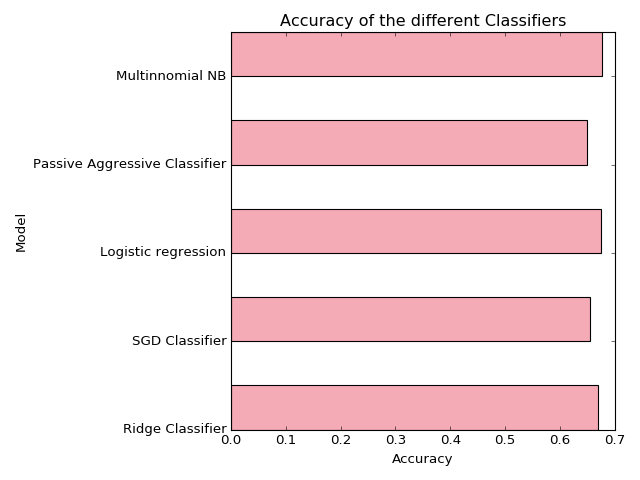

In [16]:
# Classifier - Text
#Looking at the most used words per gender doesnt yield anything particular since we all use the same common words,
#so let's try to find predictors

feature = 'all_text'
df = dataFrameText[dataFrameText['_golden']==False]
modelListText = [linear_model.RidgeClassifier(), 
             linear_model.SGDClassifier(),
             linear_model.LogisticRegression(),
             linear_model.PassiveAggressiveClassifier(),
             naive_bayes.MultinomialNB()
             ]
acc_text = np.zeros(len(modelListText))
for i in range(0, len(modelListText)):
#for i in range(2,3):
#     model_text = modelListText[i]
    modelName = modelNamesList[i]
    modelListText[i], voc_text, acc_text[i] = predictors(df, feature, modelListText[i], modelName, displayResults = False)
    
fig, ax = plt.subplots()
    
bar_width = 0.5
model_number = np.arange(len(modelListText))+1
rects1 = plt.barh(model_number,acc_text, bar_width, label = 'Brand Predictors', color = '#f5abb5')
plt.yticks(model_number,modelNamesList)
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy of the different Classifiers')
plt.tight_layout()
plt.show()

Here, as the data is much more varied and meaningful than simple color codes, we manae to obtain a prediction accuracy of about 65%. Strong predictors for male users are words such as "father", "boy", "man" or "niggas", while predictor for female users are "mom", "girl", "feminist" or "makeup", and of course, these words are anti-predictors of the opposite gender.

From the anti-predictors, it seems like female users do not tweet about sports ("player", "hit", "team", "season", "game") while male users are less susceptible to tweet about girls ("girl", "mother", "queen"). 

On the side of brads, we see that our intuitions are confirmed, as posting a link ("https") or tweeting about "news" and "weather" are typical of the brand "gender". 

Finally, some predictors for the female gender might looks quite odd, "\_ù" or "ï_" for example, but we think these are unicodes for emojis. However, we did not manage to find which ones.

## Gender prediction based on profile pictures features

Now, let's finally apply our classifiers using the profile picture contents:

Testing Ridge Classifier model for gender prediction using pic_text
Split: 1055 testing and 4223 training samples
model:  Ridge Classifier
mse: 0.2635
score:  0.858767772512
Testing SGD Classifier model for gender prediction using pic_text
Split: 1055 testing and 4223 training samples
model:  SGD Classifier
mse: 0.3062
score:  0.841706161137
Testing Logistic regression model for gender prediction using pic_text
Split: 1055 testing and 4223 training samples
model:  Logistic regression
mse: 0.3204
score:  0.850236966825
Testing Passive Aggressive Classifier model for gender prediction using pic_text
Split: 1055 testing and 4223 training samples
model:  Passive Aggressive Classifier
mse: 0.3602
score:  0.816113744076
Testing Multinnomial NB model for gender prediction using pic_text
Split: 1055 testing and 4223 training samples
model:  Multinnomial NB
mse: 0.3640
score:  0.82654028436


<IPython.core.display.Javascript object>


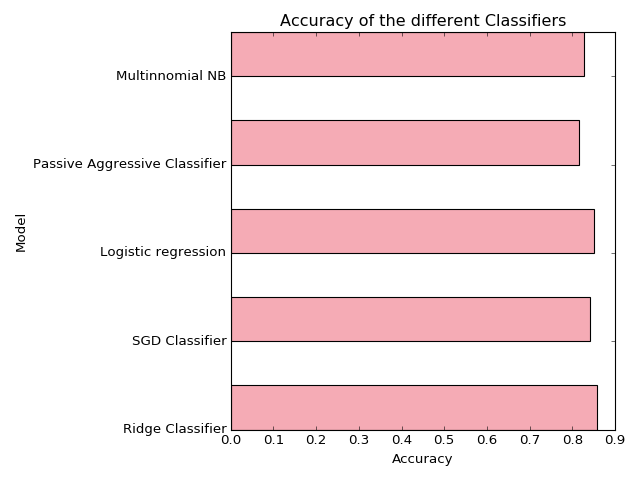

In [17]:
# Classifier - Pictures
#Looking at the most used words per gender doesnt yield anything particular since we all use the same common words,
#so let's try to find predictors

feature = 'pic_text'
df = genderConf
modelListPic = [linear_model.RidgeClassifier(), 
             linear_model.SGDClassifier(),
             linear_model.LogisticRegression(),
             linear_model.PassiveAggressiveClassifier(),
             naive_bayes.MultinomialNB()
             ]
acc_pic = np.zeros(len(modelListPic))
for i in range(0, len(modelListPic)):
#for i in range(2,3):
#     model_pic = modelListPic[i]
    modelName = modelNamesList[i]
    modelListPic[i], voc_pic, acc_pic[i] = predictors(df, feature, modelListPic[i], modelName, displayResults = False)
    
fig, ax = plt.subplots()
    
bar_width = 0.5
model_number = np.arange(len(modelListPic))+1
rects1 = plt.barh(model_number,acc_pic, bar_width, label = 'Brand Predictors', color = '#f5abb5')
plt.yticks(model_number,modelNamesList)
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy of the different Classifiers')
plt.tight_layout()
plt.show()

As the content of the profile picture is very representative of the user, the classifier manage to get up to 85% of accurate predictions, which is quite impressive. However, the predictors are not exactly as we expected them to be. Although "man" and "woman" are among the best predictors for their respective gender, we expected them to be way more important to the prediction of the gender for most of the classifiers.

Also, it seems like we have many twitter account from "actresses", or maybe many female users use pictures of actresses as their profile pictures. Unsurprisigly, "bikini" is an anti-predictor for male users. What is more surprising though is that "lingerie", "leather" and "lips" are strong predictors for brands. 

In [9]:
#Get profile pictures, to have it big just remove '_normal'
pd.options.display.max_colwidth = 100
print(dataFrame.loc[1, 'profileimage'])

from PIL import Image 
from io import BytesIO
import requests

url = dataFrame.loc[1, 'profileimage']
response = requests.get(url)
img = Image.open(BytesIO(response.content))
print(img.format)  # 'JPEG'

https://pbs.twimg.com/profile_images/539604221532700673/WW16tBbU_normal.jpeg
JPEG


In [10]:
dataFrameGold = dataFrame[dataFrame['_golden']]

dataFrameGold.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone,text_norm,description_norm,all_text
20000,815746503,True,golden,249,NaN,male,0.9612,yes,0.9612,8/5/10 8:31,...,Reimagining the #webdesign process by @InVisionApp - https://t.co/Vmb0OZU67e https://t.co/hFlWR8...,NaN,3874,10/26/15 12:40,6.587300e+17,127.0.0.1,Athens,reimagining the webdesign process by invisionapp https://t.co/vmb0ozu67e https://t.co/hflwr8tfol,maker conceptor creative developer 0xbac3a9bd #conception geek dev agile neutralite opensource p...,reimagining the webdesign process by invisionapp https://t.co/vmb0ozu67e https://t.co/hflwr8tfol...
20001,815750089,True,golden,271,NaN,brand,0.9622,yes,1.0000,9/10/14 16:30,...,#WestHam Tweets: 52: Goal. @FulhamFC double their lead. No7 Dean O'Halloran gets in behind and s...,NaN,24827,10/26/15 13:20,6.587400e+17,NaN,NaN,#westham tweets 52 goal fulhamfc double their lead no7 dean o'halloran gets in behind and scores...,we cover west ham united fc and soccer 24/7 player press is a curator of interesting sports cont...,#westham tweets 52 goal fulhamfc double their lead no7 dean o'halloran gets in behind and scores...
20002,815750297,True,golden,245,NaN,brand,1.0000,yes,1.0000,5/11/09 15:31,...,Webber: 'It's a chance for the lads to pit their wits against a League club and see where they s...,NaN,42075,10/26/15 12:40,6.587300e+17,"Wembley Stadium, London",London,webber it's a chance for the lads to pit their wits against a league club and see where they sta...,official twitter account of the football association tweeting news on england teams emirates fa ...,webber it's a chance for the lads to pit their wits against a league club and see where they sta...
20003,815750417,True,golden,245,NaN,brand,0.6408,yes,1.0000,8/1/14 13:20,...,Get Weather Updates from The Weather Channel. 15:40:07,NaN,63240,10/26/15 12:40,6.587300e+17,NaN,NaN,get weather updates from the weather channel 15:40:07,nan,get weather updates from the weather channel 15:40:07 nan
20004,815750696,True,golden,261,NaN,male,1.0000,yes,1.0000,3/26/12 14:40,...,@TheFalcoholic is like the mailman... Because he delivers! #MuteBuck &amp; #BlitzTheBooth on @Ra...,NaN,3296,10/26/15 12:40,6.587300e+17,Parts Unknown,Pacific Time (US & Canada),@thefalcoholic is like the mailman.. because he delivers mutebuck amp blitzthebooth on rabbletv ...,comedian writer @rabbletv broadcaster host of youcalledit wrestling baseball boxing and mma fan ...,@thefalcoholic is like the mailman.. because he delivers mutebuck amp blitzthebooth on rabbletv ...


In [11]:
   
text_test = str("buy the house of your dreams with weather channel news https://jkasdbvkdbv")
dataFrametest = pd.DataFrame.from_items([('text',[text_test])])
dataFrametest.head()
test_external_data(dataFrametest['text'],voc_text,modelListText[2],'text')

The predicted gender by using the text is brand with probability 0.957627771696


(array([[ 0.95762777,  0.02579235,  0.01657988]]), array([0], dtype=int64))

In [12]:
text_test2 = str("niggas in Paris, gospel with the squad and my father sport team")
pic_test2 = "man sunglass portrait"
color_test2 = "cc3300"
dataFrametest2 = pd.DataFrame.from_items([('all_text',[text_test2]), ('pic_text', [pic_test2]), ('link_color', [color_test2]), ('user_name','blabla'),('gender','male')])
dataFrametest2.head()
combine_features(modelListText[2], modelListPic[2], modelListColor[2], dataFrametest2, voc_text, voc_pic, voc_color, acc_text[1], acc_pic[1], acc_color[1])

The predicted gender by using the text is male with probability 0.960036988286
The predicted gender by using the profile picture is male with probability 0.844729032234
The predicted gender by using the link color is male with probability 0.618734510786
0.0933039687897
Overall, the predicted gender of user blabla is male with a confidence of 0.832570445471
The average success rate for this test data is 1.0


In [19]:
dataFrametest4 = pd.read_csv('test_data_utf.csv', encoding='utf-8')

dataFrametest4['link_color'] = dataFrametest4['profile_background_color']
dataFrametest4['all_text'] = [text_normalizer(s) for s in dataFrametest4['description'].str.cat(dataFrametest4['text'])]

dataFrametestfem = dataFrametest4[dataFrametest4['gender']=='female']
combine_features(modelListText[4], modelListPic[2], modelListColor[2], dataFrametest4, voc_text, voc_pic, voc_color, np.exp(10*acc_text[1]), np.exp(10*acc_pic[1]), np.exp(10*acc_color[1]))

The predicted gender by using the text is male with probability 1.0
The predicted gender by using the profile picture is male with probability 0.947416993125
The predicted gender by using the link color is female with probability 0.448221106535
0.0162333702423
Overall, the predicted gender of user realDonaldTrump is male with a confidence of 0.946836173316
The predicted gender by using the text is female with probability 1.0
The predicted gender by using the profile picture is male with probability 0.947416993125
The predicted gender by using the link color is female with probability 0.448221106535
0.0162333702423
Overall, the predicted gender of user augusten is male with a confidence of 0.814276574297
The predicted gender by using the text is female with probability 0.412073729854
The predicted gender by using the profile picture is male with probability 0.724614702037
The predicted gender by using the link color is female with probability 0.448221106535
0.0668593053995
Overall, the 